# Customer Churn Prediction

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

from sklearn.ensemble import VotingClassifier

In [2]:
import matplotlib.ticker as mtick
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, ConfusionMatrixDisplay, precision_score, recall_score

# Load Data From AWS S3 bucket

In [3]:
import boto3
import pandas as pd
from io import StringIO

s3_client = boto3.client('s3')

bucket_name = 'customer-churn-prediction-data'
object_key = 'data.csv'

response = s3_client.get_object(Bucket=bucket_name, Key=object_key)

csv_content = response['Body'].read().decode('utf-8')

csv_file_like_object = StringIO(csv_content)

df = pd.read_csv(csv_file_like_object)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

# Exploratory Data Analysis (EDA)

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.TotalCharges.dtype

dtype('float64')

In [8]:
df["PaymentMethod"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [9]:
df["PaymentMethod"] = df["PaymentMethod"].str.replace(" (automatic)", "", regex=False)
df["PaymentMethod"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

In [10]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [11]:
df.dropna(inplace=True)

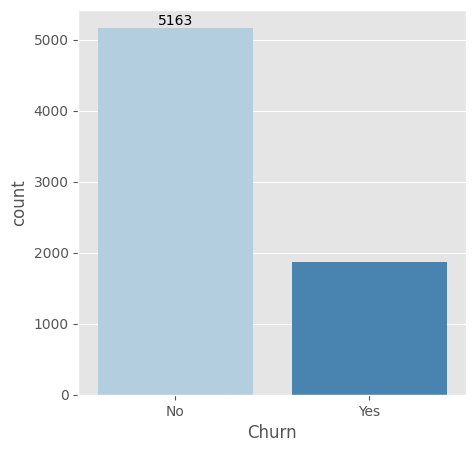

In [12]:
plt.style.use("ggplot")

plt.figure(figsize=(5,5))
ax = sns.countplot(x = df["Churn"], hue = df["Churn"], palette="Blues")
ax.bar_label(ax.containers[0])
plt.show()

In [13]:
import math


def plot_categorical_to_target(df,categorical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)
    
    fig = plt.figure(figsize = (12, 5*number_of_rows))
    
    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = df, hue = target, palette="Blues")
        ax.set_title(column)
    return plt.show()

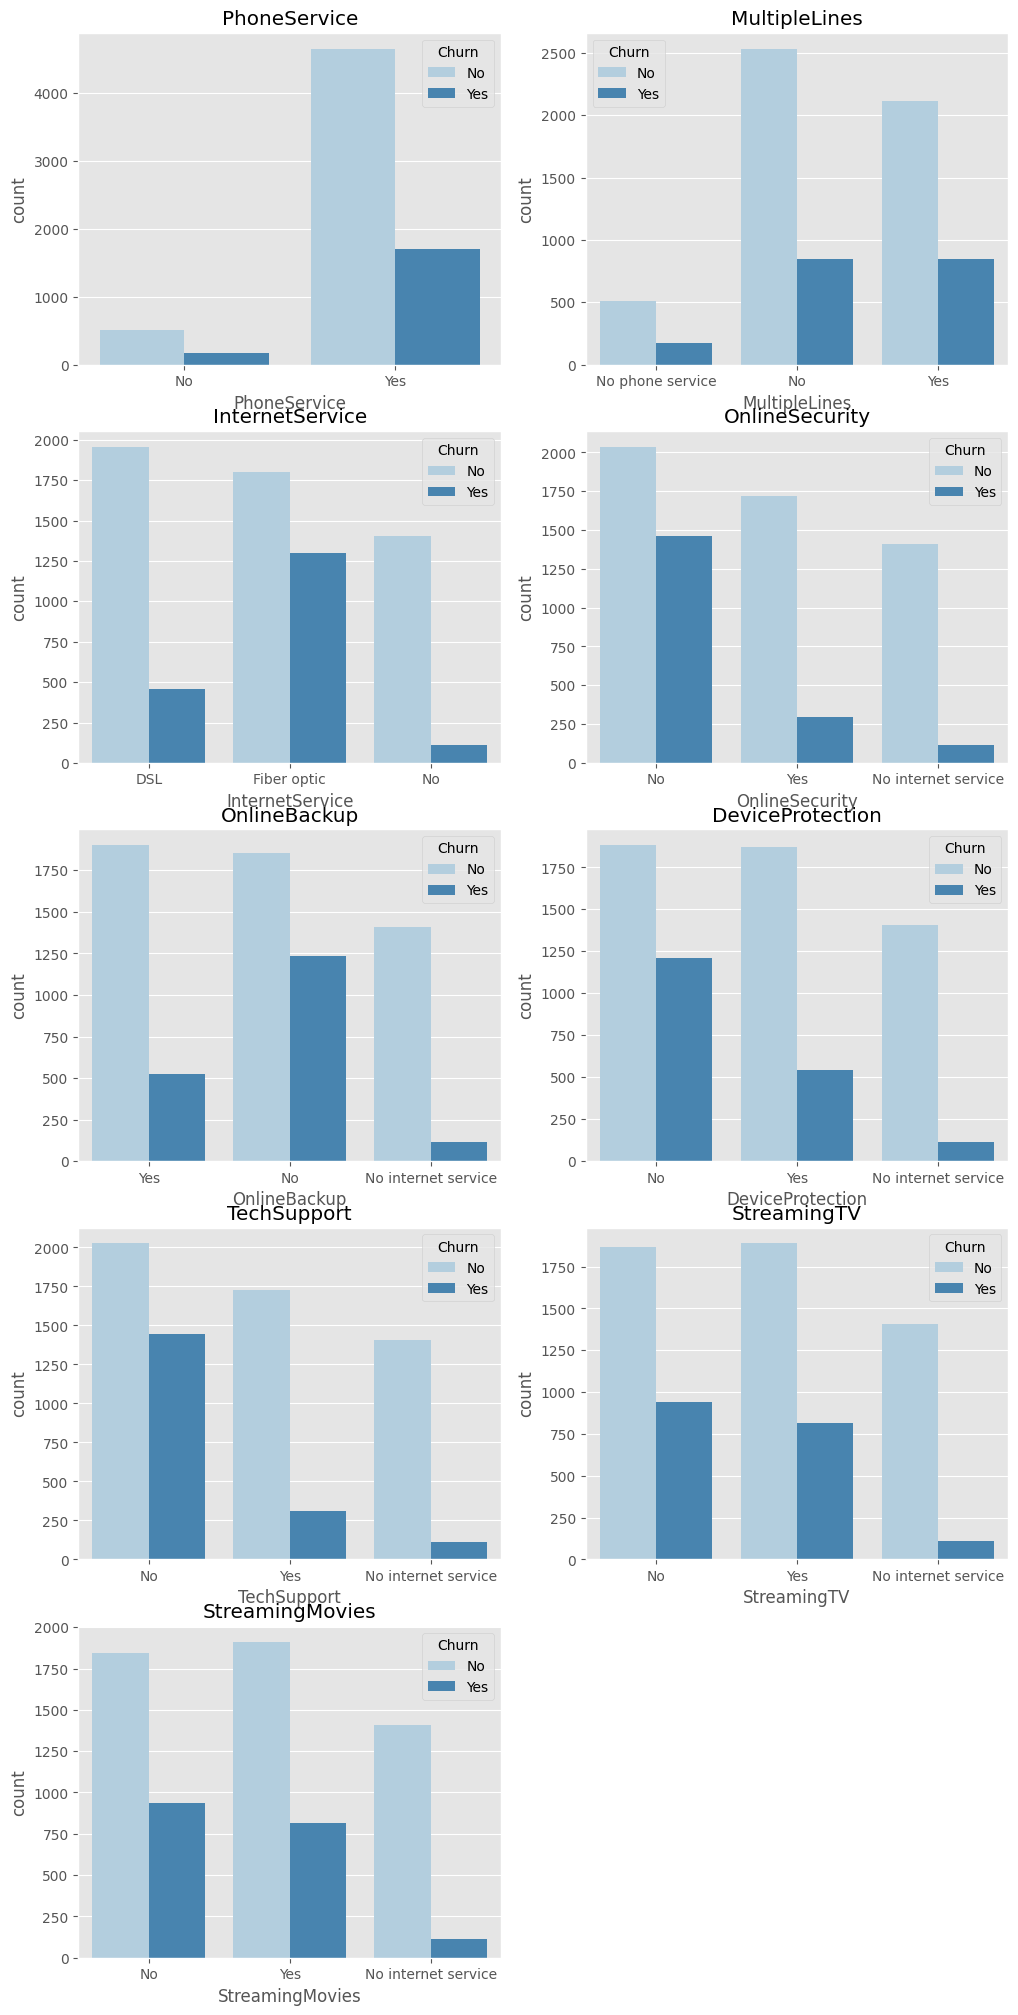

In [14]:
customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(df,customer_services, "Churn")

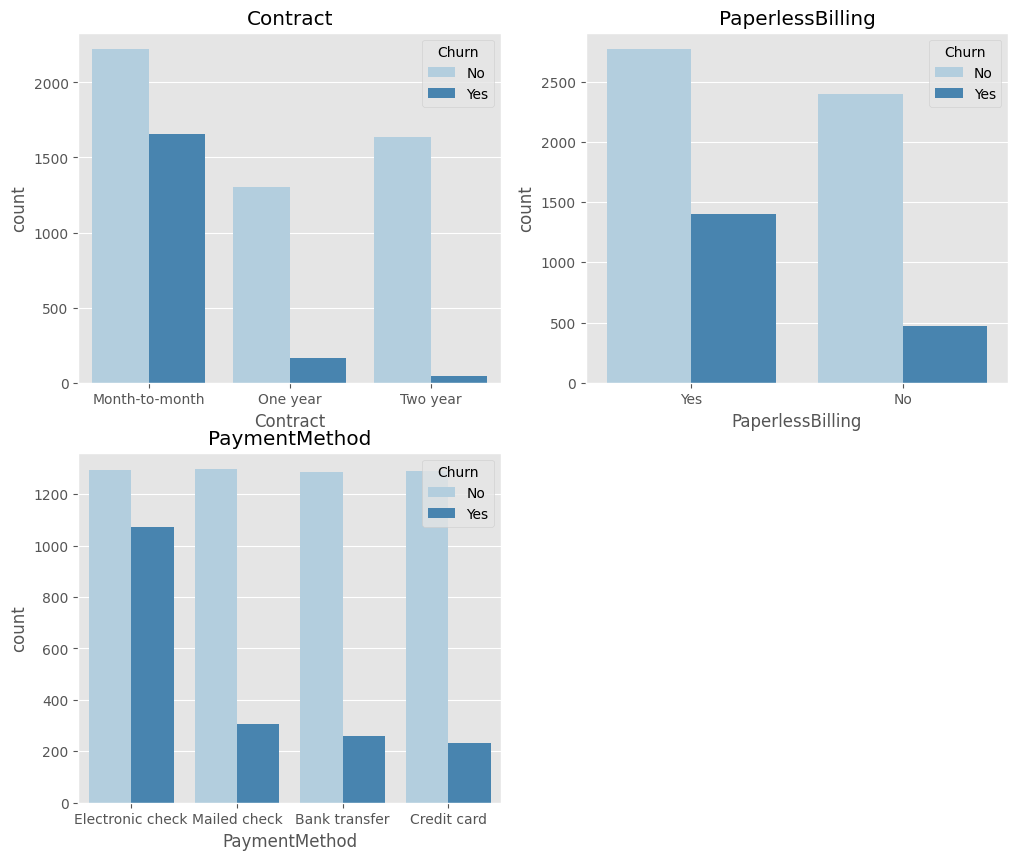

In [15]:
customer_account_cat = ["Contract","PaperlessBilling","PaymentMethod"]
plot_categorical_to_target(df,customer_account_cat,"Churn")

In [16]:
def histogram_plots(df, numerical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    
    for index, column in enumerate(numerical_values,1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.kdeplot(df[column][df[target]=="Yes"] ,fill = True)
        ax = sns.kdeplot(df[column][df[target]=="No"], fill = True)
        ax.set_title(column)
        ax.legend(["Churn","No Churn"], loc='upper right')
    plt.savefig("numerical_variables.png", dpi=300)
    return plt.show()

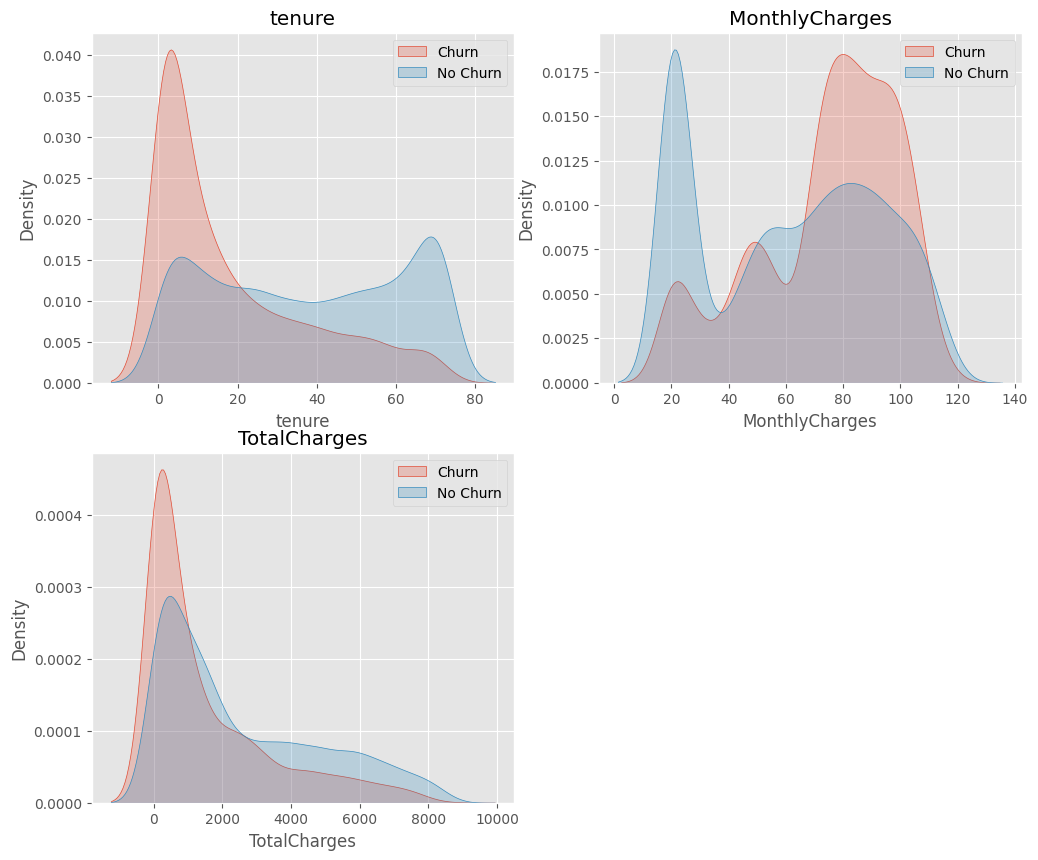

In [17]:
customer_account_num = ["tenure", "MonthlyCharges","TotalCharges"]
histogram_plots(df, customer_account_num, "Churn")

## Outlier Checking with Boxplot for Numerical Variables

In [18]:
def outlier_check_boxplot(df,numerical_values):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    for index, column in enumerate(numerical_values, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.boxplot(x = column, data = df, palette = "Blues")
        ax.set_title(column)
    plt.savefig("Outliers_check.png", dpi=300)
    return plt.show()

/tmp/ipykernel_5058/4231409617.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = column, data = df, palette = "Blues")
/tmp/ipykernel_5058/4231409617.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = column, data = df, palette = "Blues")
/tmp/ipykernel_5058/4231409617.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = column, data = df, palette = "Blues")


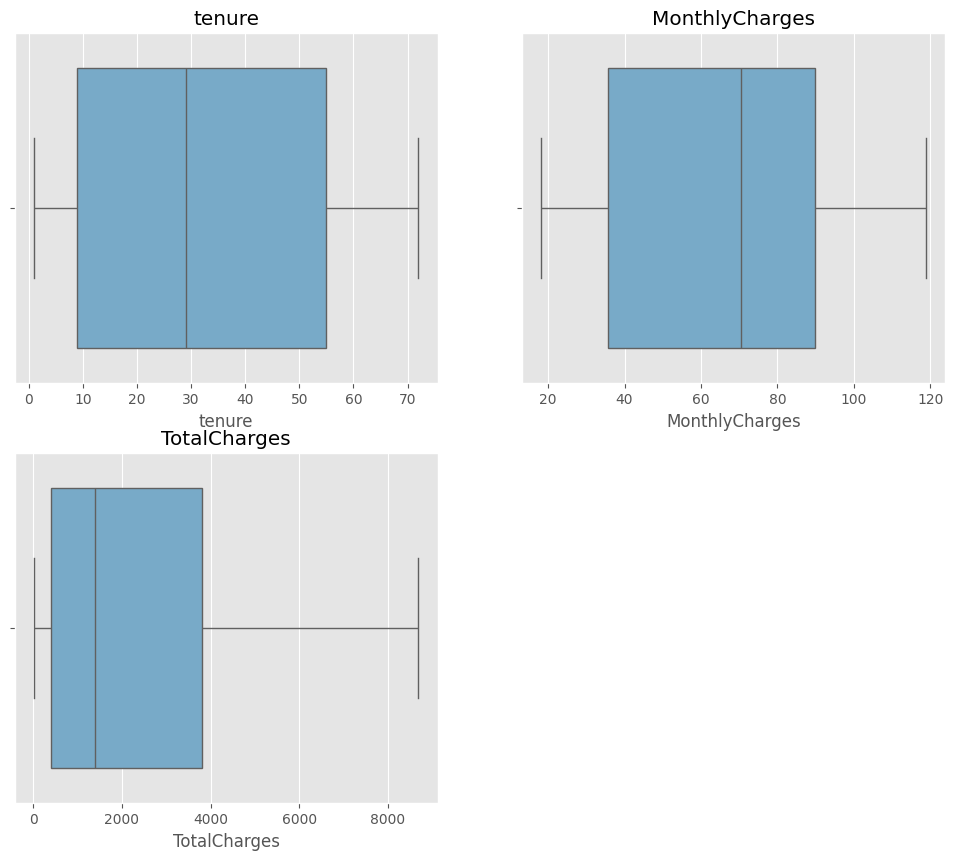

In [19]:
numerical_values = ["tenure","MonthlyCharges","TotalCharges"]
outlier_check_boxplot(df,numerical_values)

# Feature Engineering


In [20]:
feature_le = ["Partner","Dependents","PhoneService", "Churn","PaperlessBilling"]
def label_encoding(df,features):
    for i in features:
        df[i] = df[i].map({"Yes":1, "No":0})
    return df

df = label_encoding(df,feature_le)
df["gender"] = df["gender"].map({"Female":1, "Male":0})

In [21]:
features_ohe = ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                "DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod"]
df_ohe = pd.get_dummies(df, columns=features_ohe)

In [22]:
from sklearn.preprocessing import MinMaxScaler


features_mms = ["tenure","MonthlyCharges","TotalCharges"]

df_mms = pd.DataFrame(df_ohe, columns=features_mms)
df_remaining = df_ohe.drop(columns=features_mms)

mms = MinMaxScaler(feature_range=(0,1))
rescaled_feature = mms.fit_transform(df_mms)

rescaled_feature_df = pd.DataFrame(rescaled_feature, columns=features_mms, index=df_remaining.index)
df = pd.concat([rescaled_feature_df,df_remaining],axis=1)

In [23]:
df.drop('customerID', axis=1, inplace=True)

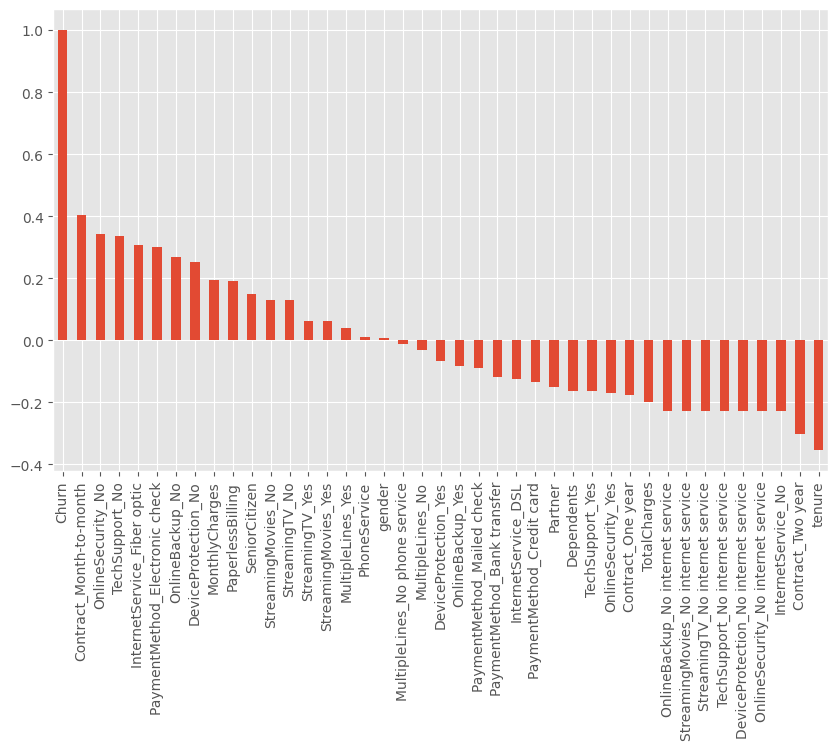

In [24]:
plt.figure(figsize=(10,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.savefig("correlation.png", dpi=300)
plt.show()

# Train Test Split

In [25]:
X = df.drop(columns = "Churn")
y = df.Churn

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 40), (1407, 40), (5625,), (1407,))

In [26]:
def feature_weights(X_df, classifier, classifier_name):
    weights = pd.Series(classifier.coef_[0], index = X_df.columns.values).sort_values(ascending=False)
    
    top_10_weights = weights[:10]
    plt.figure(figsize=(7,6))
    plt.title(f"{classifier_name} - Top 10 Features")
    top_10_weights.plot(kind="bar")
    
    bottom_10_weights = weights[len(weights)-10:]
    plt.figure(figsize=(7,6))
    plt.title(f"{classifier_name} - Bottom 10 Features")
    bottom_10_weights.plot(kind="bar")
    print("")

In [27]:
def confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred, classifier, classifier_name):
    cm = confusion_matrix(y_pred,y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot()
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.show()
    
    print(f"Accuracy Score Test = {accuracy_score(y_pred,y_test)}")
    print(f"Accuracy Score Train = {classifier.score(X_train,y_train)}")
    return print("\n")

In [28]:
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities,classifier_name):
    y_pred_prob = y_pred_probabilities[:,1]
    fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.plot([0,1],[0,1],"k--")
    plt.plot(fpr,tpr,label=f"{classifier_name}")
    plt.title(f"{classifier_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return print(f"AUC Score (ROC):{roc_auc_score(y_test,y_pred_prob)}")

In [29]:
def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    y_pred_prob = y_pred_probabilities[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall,precision, label=f"{classifier_name}")
    plt.title(f"{classifier_name}-ROC Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    f1_score_result, auc_score = f1_score(y_test,y_pred), auc(recall,precision)
    return print(f"f1 Score : {f1_score_result} \n AUC Score (PR) : {auc_score}")

# K-Nearest Neighbor

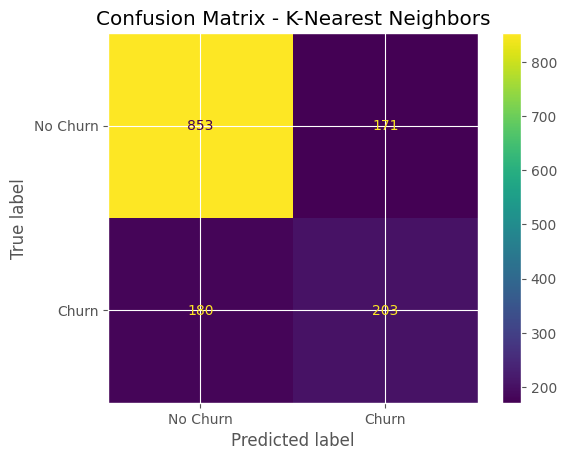

Accuracy Score Test = 0.7505330490405118
Accuracy Score Train = 0.8359111111111112




In [30]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_pred_knn_proba = knn.predict_proba(X_test)

confusion_matrix_plot(X_train,y_train,X_test, y_test, y_pred_knn, knn, "K-Nearest Neighbors")

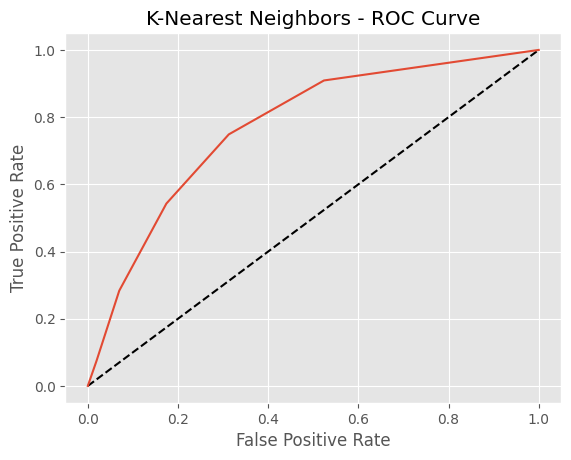

AUC Score (ROC):0.7718769898173121


In [31]:
roc_curve_auc_score(X_test,y_test,y_pred_knn_proba, "K-Nearest Neighbors")

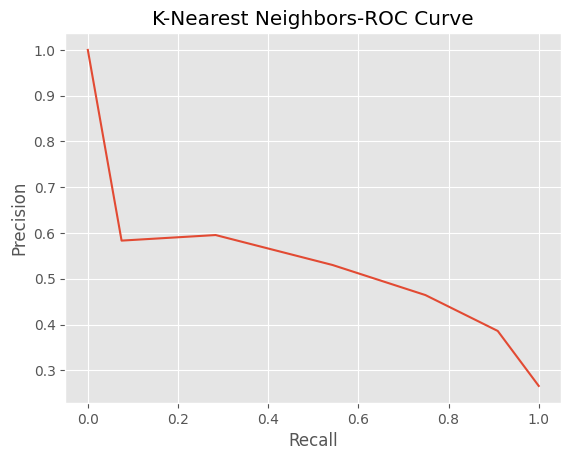

f1 Score : 0.5363276089828268 
 AUC Score (PR) : 0.5283439083015596


In [32]:
precision_recall_curve_and_scores(X_test,y_test,y_pred_knn,y_pred_knn_proba,"K-Nearest Neighbors")

# Logistic Regression

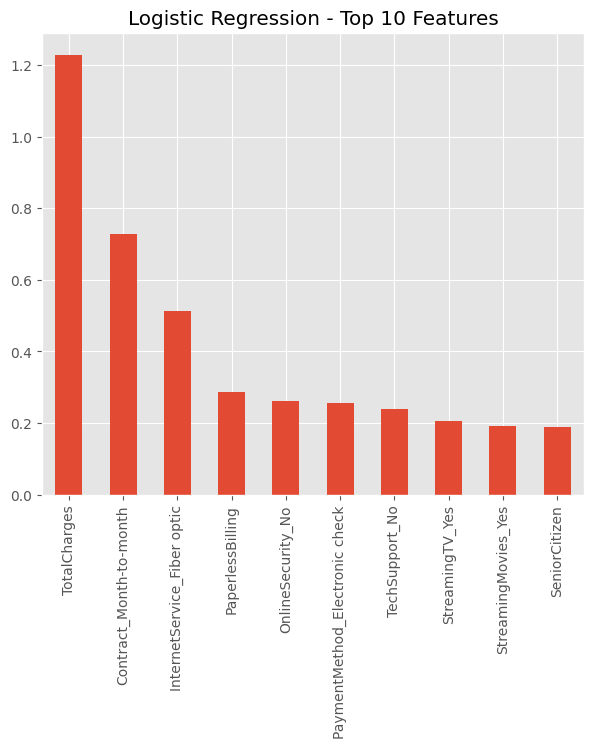

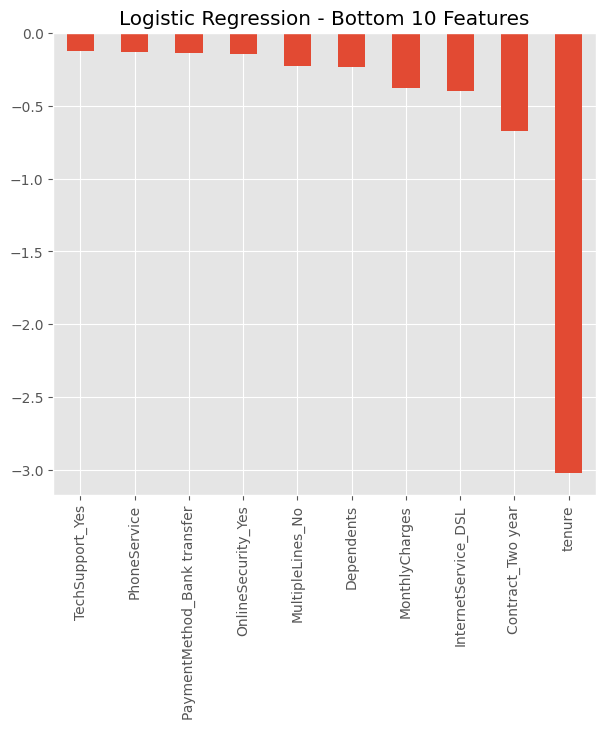

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_proba = logreg.predict_proba(X_test)

feature_weights(X_train,logreg,"Logistic Regression")

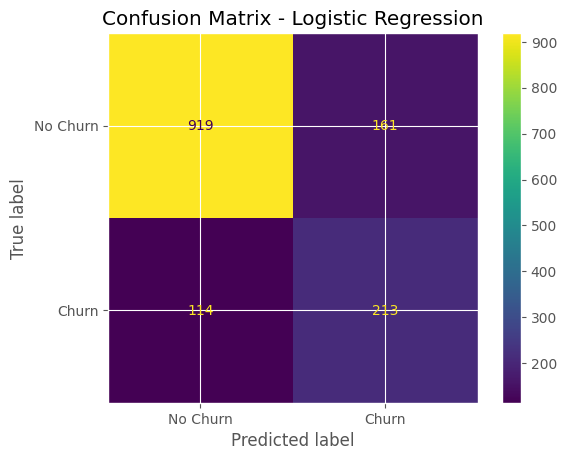

Accuracy Score Test = 0.8045486851457001
Accuracy Score Train = 0.8048




In [36]:
confusion_matrix_plot(X_train,y_train,X_test,y_test, y_pred_logreg,logreg,"Logistic Regression")

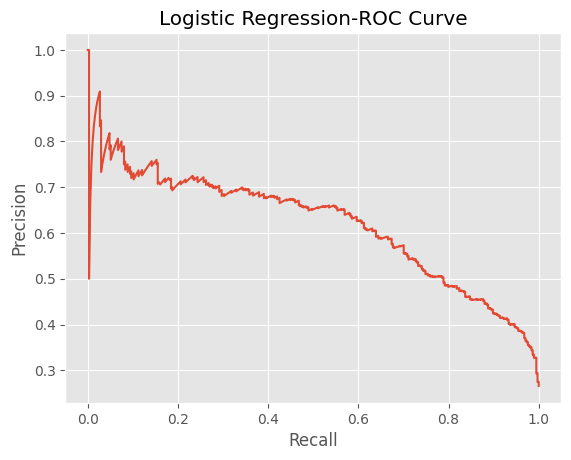

f1 Score : 0.5363276089828268 
 AUC Score (PR) : 0.6185957002131842


In [33]:
precision_recall_curve_and_scores(X_test,y_test,y_pred_knn,y_pred_logreg_proba,"Logistic Regression")

# Neural Network

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [59]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
class ChurnNet(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
